# ChaRT

This notebook combines the

- `prep_chart`
- `run_chart`
- `intro_chart_data`
- `max`
- `psf_image`

threads into one.

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


In [2]:
/bin/rm -rf 942
download_chandra_obsid 942 --exclude=vvref,osol,eph1,evt2

chandra_repro 942 out=`pwd` clob+


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits      144 Mb  ####################            3 s  42811.4 kb/s
  asol     fits       11 Mb  ####################          < 1 s  54639.3 kb/s
  mtl      fits        2 Mb  ####################          < 1 s  24106.0 kb/s
  stat     fits        2 Mb  ####################          < 1 s  39963.3 kb/s
  aqual    fits      772 Kb  ####################          < 1 s  28068.2 kb/s
  bias     fits      496 Kb  ####################          < 1 s  13385.9 kb/s
  bias     fits      445 Kb  ####################          < 1 s  18676.3 kb/s
  bias     fits      442 Kb  ####################          < 1 s  21837.4 kb/s
  bias     fits      438 Kb  ####################          < 1 s  20830.4 kb/s
  bias     fits      437 Kb  ####################          < 1 s  18450.6 kb/s
  bias     fits      428 Kb  ####################    

In [3]:
ra="12:16:56.990"
dec="+37:43:35.69"
myid=`date +%s`

[1] 2756
[1]+  Done                    ds9 acisf00942_repro_evt2.fits -scale log -regions command "fk5;circle(${ra},${dec},0.1667')" -pan to ${ra} ${dec} fk5 -bin factor 1 -zoom 4 -saveimage png ds9_01.png


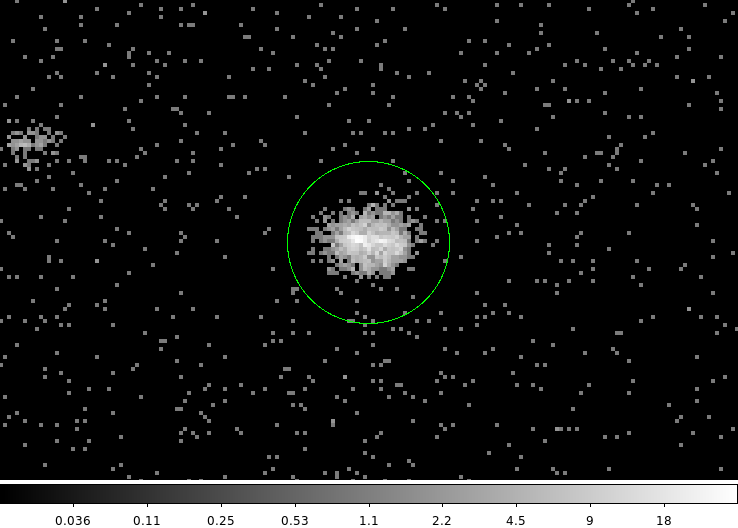

In [4]:
ds9 acisf00942_repro_evt2.fits \
  -scale log \
  -region format ds9 \
  -region command "fk5;circle(${ra},${dec},0.1667')" \
  -pan to ${ra} ${dec} fk5 \
  -bin factor 1 -zoom 4 \
  -saveimage png ds9_01.png &

sleep 10
xpaset -p ds9 quit
display < ds9_01.png

### detect coords


In [5]:
punlearn dmcoords
dmcoords acisf00942_repro_evt2.fits op=cel ra=${ra} dec=${dec} celfmt=hms
pget dmcoords theta phi

5.962619244223243
197.0927445449041


## Spectral Shape

### Upload file

In [6]:
specextract "acisf00942_repro_evt2.fits[sky=circle(${ra},${dec},20)]" ngc4244 clob+

Running specextract
Version: 26 May 2021

Using event file acisf00942_repro_evt2.fits[sky=circle(12:16:56.990,+37:43:35.69,20)]

Aspect solution file pcadf00942_001N001_asol1.fits found.

Bad-pixel file acisf00942_repro_bpix1.fits found.

Mask file acisf00942_001N005_msk1.fits found.

Setting bad pixel file 

Extracting src spectra 

Creating src ARF 

Using mkacisrmf...

Creating src RMF 

Grouping src spectrum 

Updating header of ngc4244.pi with RESPFILE and ANCRFILE keywords.

Updating header of ngc4244_grp.pi with RESPFILE and ANCRFILE keywords.



read ARF file ngc4244.arf
read RMF file ngc4244.rmf
Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 35113.9
Final fit statistic   = 83.7215 at function evaluation 72
Data points           = 93
Degrees of freedom    = 90
Probability [Q-value] = 0.666149
Reduced statistic     = 0.930239
Change in statistic   = 35030.2
   abs1.nH        0.421028     +/- 0.0537392   
   p1.gamma       4.94907      +/- 0.304912    
   p1.ampl        0.000324726  +/- 5.30461e-05 
Created: 1636553544.dat


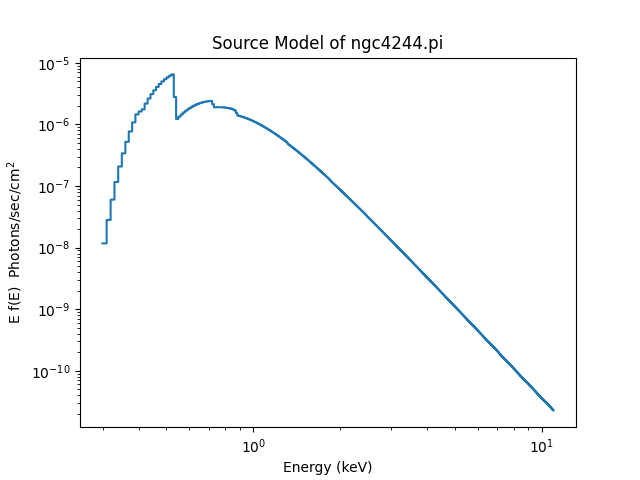

In [7]:
cat << EOM > s1.py
from sherpa.astro.ui import *
load_data("ngc4244.pi")
group_counts(10)
notice(0.4,6.0)
set_source( xsphabs.abs1 * powlaw1d.p1)
abs1.nh = 0.5
guess(p1)
fit()
set_analysis(1, "energy", "rate", factor=1)
plot_source()

import matplotlib.pylab as plt
plt.xscale("log")
plt.yscale("log")
plt.savefig("sherpa_01.png")
#print_window("sherpa_01.png","export.clobber=True")

from sherpa_contrib.chart import *
save_chart_spectrum("${myid}.dat", elow=0.4, ehigh=6.0)

EOM

python s1.py
display < sherpa_01.png 

In [8]:
dmlist ${myid}.dat cols

 
--------------------------------------------------------------------------------
Columns for Table Block 1636553544.dat
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   elo                               Real8          -Inf:+Inf            
   2   ehi                               Real8          -Inf:+Inf            
   3   spectrum                          Real8          -Inf:+Inf            


### Monochromatic energy

In [9]:
srcflux acisf00942_repro_evt2.fits "${ra} ${dec}" flux psfmethod=quick verbose=0 clob+
dmkeypar flux_broad.flux net_photflux_aper echo+        

0.000170186335973179


## Aspect Information

### Specify OBS_ID value

In [10]:
dmkeypar acisf00942_repro_evt2.fits OBS_ID echo+

942


In [11]:
dmkeypar acisf00942_repro_evt2.fits OBI_NUM echo+

1


### Upload asol file

In [12]:
echo "DATE-OBS calcForce" > hdr_lookup.txt
echo "DATE-END calcForce" >> hdr_lookup.txt
echo "TSTART calcForce" >> hdr_lookup.txt
echo "TSTOP calcForce" >> hdr_lookup.txt
dmmerge @acisf00942_asol1.lis pcad_asol.fits lookupTab=hdr_lookup.txt clob+

### No dither

In [13]:
dmlist acisf00942_repro_evt2.fits header,clean | grep _NOM

RA_NOM                     184.3418938417 [deg]     Nominal RA
DEC_NOM                     37.7818775744 [deg]     Nominal Dec
ROLL_NOM                   230.8704994876 [deg]     Nominal Roll


In [14]:
dmmakepar acisf00942_repro_evt2.fits hdr.par clob+
grep _nom hdr.par

ra_nom,r,h,184.3418938417,,,"Nominal RA [deg]"
dec_nom,r,h,37.781877574364,,,"Nominal Dec [deg]"
roll_nom,r,h,230.87049948755,,,"Nominal Roll [deg]"


## Run CHaRT

In [15]:

curl \
  -F email=${USER}@head.cfa.harvard.edu \
  -F coords=cel \
  -F ra=${ra} \
  -F dec=${dec} \
  -F asol=obi \
  -F obsid=942 \
  -F obinum=1\
  -F how_many=numiter \
  -F niter=10\
  -F randseed=32767 \
  -F energy=upload_spectrum \
  -F spectrum=@${myid}.dat \
  https://saotrace.cfa.harvard.edu/cgi-bin/runwrapper


    <html>
    <head><title>ChaRT Job Submitted</title></head>
    <body>
        <h1>ChaRT v2</h1>
    Job submitted.  You will recieve an email from cxc_rays@head.cfa.harvard.edu when the job is complete or if there are any errors.
    </body>
    </html>


In [16]:
sleep 10
max_tries=10
try=1

get_cmd="curl -s -O https://saotrace.cfa.harvard.edu/pickup/HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered.tar.gz"
echo $get_cmd

$get_cmd
stt=$?
while test $stt -ne 0 -a $try -le $max_tries
do
  echo Attempt $try of $max_tries
  sleep 10
  try=`echo $try + 1| bc `
  $get_cmd
  stt=$?  
done

if test $stt -ne 0
then
  echo ChaRT Timed Out
fi




curl -s -O https://saotrace.cfa.harvard.edu/pickup/HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered.tar.gz


## Download, intro_data_chart

In [17]:
tar xvfz HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered.tar.gz

HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0002_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0001_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0000_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0008_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0003_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0005_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0009_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0004_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0006_rays.fits
HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0007_rays.fits


In [18]:
dmlist HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block PSFRAYS
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   rt_cosx              none         Real8          -0.99955486303817:   -0.99764895820946 Label for field
   2   rt_cosy              none         Real8          -0.06430099113787:    0.06267061028205 Label for field
   3   rt_cosz              none         Real8          -0.06042128212595:    0.06201398069612 Label for field
   4   rt_kev               KeV          Real8          0.40001209364319:        5.8122639775 Label for field
   5   rt_x                 mm           Real8          -10079.770:   -10079.770 Label for field
   6   rt_y                 mm           Real8          -76.3245922374:       29.9410040569 Label for field
   7   rt_z                 mm           Real8          -18.1259441110:       23.9538474092

In [19]:
dmlist HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits keys

 
--------------------------------------------------------------------------------
Header keys for block PSFRAYS
--------------------------------------------------------------------------------
 
0001 SRFNO                2                              Int4         
0002 SRC_E                INDEF [keV]                    String       Energy used to generate rays
0003 SRC_DENS             0 [r/mm^2]                     Int4         Ray density
0004 SRC_FLUX             INDEF                          String       Source flux
0005 SRC_SPEC             1636553544.dat                 String       Spectrum used to generate rays
0006 SRC_EXPT                 50315.5830989930 [sec]     Real8        Exposure time of simulation
0007 TOTCTS               0                              Int4         Total counts (weight) in PSF image
0008 SRC_THET                     5.9626192442 [arcmin]  Real8        input off axis angle
0009 SRC_PHI                    197.0927445449 [deg]     Real8        input

In [20]:
dmlist "HRMA_ra184.23746_dec37.72658_${myid}.dat*_rays.fits" keys | grep PSFSEED2

0016 PSFSEED2             32767                          Int4         Secondary random seed
0016 PSFSEED2             32768                          Int4         Secondary random seed
0016 PSFSEED2             32770                          Int4         Secondary random seed
0016 PSFSEED2             32773                          Int4         Secondary random seed
0016 PSFSEED2             32777                          Int4         Secondary random seed
0016 PSFSEED2             32782                          Int4         Secondary random seed
0016 PSFSEED2             32788                          Int4         Secondary random seed
0016 PSFSEED2             32795                          Int4         Secondary random seed
0016 PSFSEED2             32803                          Int4         Secondary random seed
0016 PSFSEED2             32812                          Int4         Secondary random seed


In [21]:
dmlist "HRMA_ra184.23746_dec37.72658_${myid}.dat*_rays.fits" counts

8723    
8714    
8574    
8732    
8545    
8697    
8821    
8671    
8641    
8680    


## Run MARX

### Install MARX

In [22]:
#echo | install_marx  `pwd` < /dev/null > /dev/null 2>&1 

In [23]:
#source ./marx-5*/setup_marx.sh

### Get coords

In [24]:
dmlist acisf00942_repro_evt2.fits header | grep _NOM

0066 RA_NOM                     184.3418938417 [deg]     Real8        Nominal RA
0067 DEC_NOM                     37.7818775744 [deg]     Real8        Nominal Dec
0068 ROLL_NOM                   230.8704994876 [deg]     Real8        Nominal Roll


In [25]:
dra=`dmkeypar HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits SRC_RA echo+`
echo $dra

184.2374583333333


In [26]:
ddec=`dmkeypar HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits SRC_DEC echo+`
echo $ddec

37.72658055555556


In [27]:
dmkeypar HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits ASOLFILE echo+

pcadf00942_001N001_asol1.fits


### Run simulate_psf

In [28]:
pset simulate_psf infile=acisf00942_repro_evt2.fits 
pset simulate_psf outroot=chart
pset simulate_psf ra=$dra
pset simulate_psf dec=$ddec
pset simulate_psf simulator=file
pset simulate_psf rayfile=HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits
pset simulate_psf projector=marx
pset simulate_psf random_seed=34455
simulate_psf mode=h

simulate_psf
          infile = acisf00942_repro_evt2.fits
         outroot = chart
              ra = 184.2374583333333
             dec = 37.72658055555556
    spectrumfile = 
      monoenergy = INDEF
            flux = INDEF
       simulator = file
         rayfile = HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0000_rays.fits
       projector = marx
     random_seed = 34455
            blur = 0.07000000000000001
  readout_streak = no
          pileup = no
           ideal = yes
        extended = yes
         binsize = 1
          numsig = 7
         minsize = INDEF
         numiter = 1
        keepiter = no
        asolfile = 
       marx_root = /export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1
         verbose = 1
            mode = h

Started check_setup
Finished check_setup
Performing iteration 1 of 1
Started run_marx
Finished run_marx
Started create_psf_image
Finished create_psf_image
Started create_average_image
Finished create_average_image

Final output PSF 

[1] 3854
[1]+  Done                    ds9 acisf00942_repro_evt2.fits -scale log -pan to ${ra} ${dec} fk5 -bin factor 1 -zoom 4 chart.psf -scale log -match frame wcs -saveimage png ds9_02.png


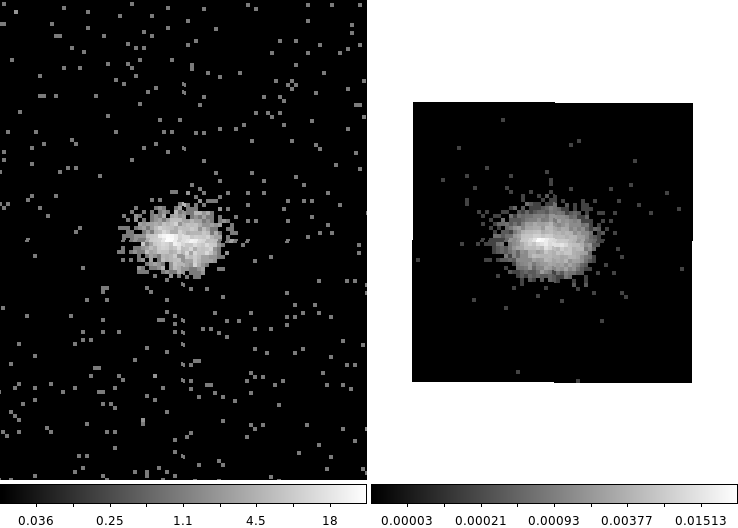

In [29]:
ds9 acisf00942_repro_evt2.fits \
  -scale log \
  -pan to ${ra} ${dec} fk5 \
  -bin factor 1 -zoom 4 \
  chart.psf -scale log \
  -match frame wcs \
  -saveimage png ds9_02.png &
sleep 10
xpaset -p ds9 quit
display < ds9_02.png 


### Combine all iterations

In [30]:
/bin/ls -1 HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i*_rays.fits > rays.lis

pset simulate_psf outroot=chart_coadd
pset simulate_psf rayfile=@rays.lis
simulate_psf mode=h

simulate_psf
          infile = acisf00942_repro_evt2.fits
         outroot = chart_coadd
              ra = 184.2374583333333
             dec = 37.72658055555556
    spectrumfile = 
      monoenergy = INDEF
            flux = INDEF
       simulator = file
         rayfile = @rays.lis
       projector = marx
     random_seed = 34455
            blur = 0.07000000000000001
  readout_streak = no
          pileup = no
           ideal = yes
        extended = yes
         binsize = 1
          numsig = 7
         minsize = INDEF
         numiter = 1
        keepiter = no
        asolfile = 
       marx_root = /export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1
         verbose = 1
            mode = h

Started check_setup
Finished check_setup
10 rayfiles provided; ignoring numiter=1 parameter
Performing iteration 1 of 10
Started run_marx
Finished run_marx
Started create_psf_image
Finished create_psf_image
Performing iteration 2 of 10
Started run_marx
Finished run_marx
Started create

[1] 4381
[1]+  Done                    ds9 acisf00942_repro_evt2.fits -scale log -pan to ${ra} ${dec} fk5 -bin factor 1 -zoom 4 chart_coadd.psf -scale log -match frame wcs -saveimage png ds9_03.png


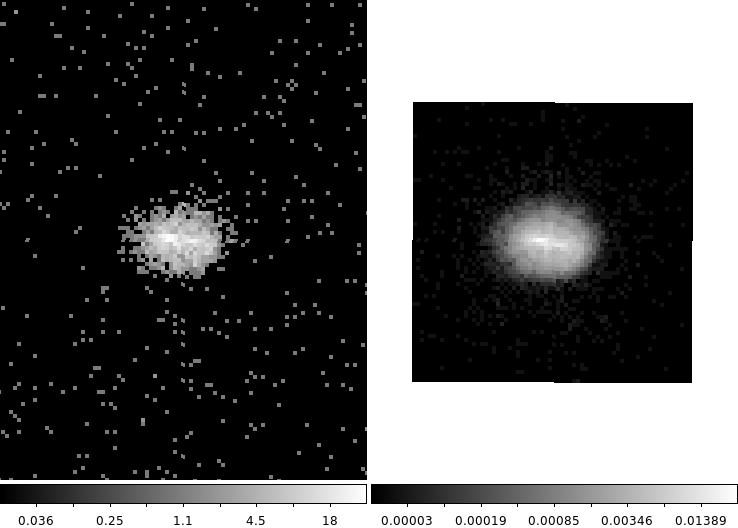

In [31]:
ds9 acisf00942_repro_evt2.fits \
  -scale log \
  -pan to ${ra} ${dec} fk5 \
  -bin factor 1 -zoom 4 \
  chart_coadd.psf -scale log \
  -match frame wcs \
  -saveimage png ds9_03.png &
sleep 10
xpaset -p ds9 quit
display < ds9_03.png 


---
## Step By Step


In [32]:
cp -fv $MARX_ROOT/share/marx/pfiles/marx.par ./marx.par
chmod +w ./marx.par

'/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/pfiles/marx.par' -> './marx.par'


In [33]:
pset ./marx SAOSACFile=HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits
pset ./marx OutputDir=marx_output_i0000.dir
pset ./marx SourceType=SAOSAC

pset ./marx RA_Nom=184.34304
pset ./marx Dec_Nom=37.78089
pset ./marx Roll_Nom=230.87537
pset ./marx SourceRA=184.237458333
pset ./marx SourceDEC=37.7265805556

pset ./marx DitherModel=FILE
pset ./marx DitherFile=pcadf00942_001N001_asol1.fits

pset ./marx DetectorType=ACIS-S 
pset ./marx GratingType=NONE
pset ./marx ExposureTime=0.0

In [34]:
dmlist acisf00942_repro_evt2.fits header | grep SIM_

0053 SIM_X                   -0.68282252473119 [mm]      Real8        SIM focus pos
0054 SIM_Y                                   0 [mm]      Real8        SIM orthogonal axis pos
0055 SIM_Z                     -190.1400660499 [mm]      Real8        SIM translation stage pos


In [35]:
pset ./marx DetOffsetX=0.00144494
pset ./marx DetOffsetY=0
pset ./marx DetOffsetZ=-0.00754295

In [36]:
pset ./marx AspectBlur=0.25

In [37]:
marx @@./marx.par

MARX version 5.5.1, Copyright (C) 2002-2020 Massachusetts Institute of Technology

	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/EKCHDOS06.rdb
Reading binary HRMA optical constants:
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/iridium.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_1.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_3.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_4.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_6.dat
Reading scattering tables
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_h1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p3_M.bin
	/export/CIAOT/ciaot

In [38]:
ls marx_output_i0000.dir

b_energy.dat   detector.dat  obs.par      sky_roll.dat  xpos.dat    zcos.dat
det_dy.dat     energy.dat    pha.dat      time.dat      ycos.dat    zpos.dat
det_dz.dat     marx.par      sky_dec.dat  xcos.dat      ypixel.dat
det_theta.dat  mirror.dat    sky_ra.dat   xpixel.dat    ypos.dat


In [39]:
marx2fits --pixadj=EDSER marx_output_i0000.dir marx_output_i0000.fits 

Reading subpix file /export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-07-22subpixN0001_marx.fits
Examining marx_output_i0000.dir/time.dat
Examining marx_output_i0000.dir/detector.dat
Examining marx_output_i0000.dir/energy.dat
Examining marx_output_i0000.dir/b_energy.dat
Examining marx_output_i0000.dir/xpos.dat
Examining marx_output_i0000.dir/ypos.dat
Examining marx_output_i0000.dir/zpos.dat
Examining marx_output_i0000.dir/xcos.dat
Examining marx_output_i0000.dir/ycos.dat
Examining marx_output_i0000.dir/zcos.dat
Examining marx_output_i0000.dir/xpixel.dat
Examining marx_output_i0000.dir/ypixel.dat
Examining marx_output_i0000.dir/pha.dat
Examining marx_output_i0000.dir/mirror.dat
Examining marx_output_i0000.dir/sky_ra.dat
Examining marx_output_i0000.dir/sky_dec.dat
Examining marx_output_i0000.dir/sky_roll.dat
Examining marx_output_i0000.dir/det_dy.dat
Examining marx_output_i0000.dir/det_dz.dat
Examining marx_output_i0000.dir/det_theta.dat


[1] 4510
[1]+  Done                    ds9 acisf00942_repro_evt2.fits -pan to ${ra} ${dec} fk5 -bin factor 1 -scale log marx_output_i0000.fits -scale log -pan to ${ra} ${dec} fk5 -bin factor 1 -zoom 4 -match frame wcs -saveimage png ds9_04.png
XPA$ERROR no 'xpaset' access points match template: ds9


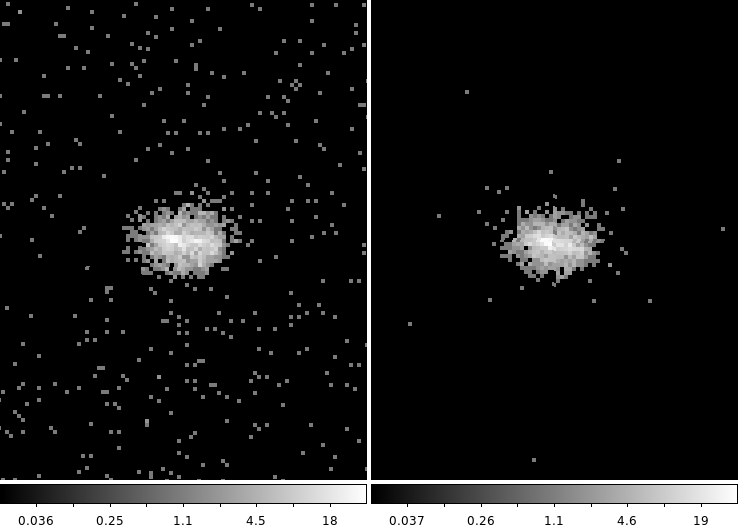

In [40]:
ds9 acisf00942_repro_evt2.fits \
  -pan to ${ra} ${dec} fk5 \
  -bin factor 1  \
  -scale log \
  marx_output_i0000.fits  -scale log \
  -pan to ${ra} ${dec} fk5 \
  -bin factor 1 -zoom 4 \
  -match frame wcs \
  -saveimage png ds9_04.png &
sleep 10
xpaset -p ds9 quit
display < ds9_04.png 


## PSF Image


In [41]:
dmlist marx_output_i0000.fits blocks

 
--------------------------------------------------------------------------------
Dataset: marx_output_i0000.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: NULL                           Null        
Block    2: EVENTS                         Table        22 cols x 1561     rows
Block    3: GTI4                           Table         2 cols x 1        rows
Block    4: GTI5                           Table         2 cols x 1        rows
Block    5: GTI6                           Table         2 cols x 1        rows
Block    6: GTI7                           Table         2 cols x 1        rows
Block    7: GTI8                           Table         2 cols x 1        rows
Block    8: GTI9                           Table         2 cols x 1        rows
Block    9: MARX_PAR                    

In [42]:
dmlist marx_output_i0000.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block EVENTS
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   TIME                 s            Real8          362912400.0:362962714.1465607882 time since observation start
   2   CCD_ID                            Int2           0:9                  CCD id number
   3   NODE_ID                           Int2           -                    0-4
   4   EXPNO                             Int4           0:2147483647         Exposure number
   5   chip(CHIPX,CHIPY)    pixel        Int2           2:1023               CHIP X
   6   tdet(TDETX,TDETY)    pixel        Int4           2:8191               Detector X
   7   det(DETX,DETY)       pixel        Real4          0.50:     8192.50    Focal Plane X
   8   sky(X,Y)             pixel        Real4          0.50:     8192.50    sky X pixel
   9 

In [43]:
dmlist HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_i0000_rays.fits header | egrep 'SRC_(RA|DEC)'

0010 SRC_RA               184.2374583333333 [deg]        String       Input source Right Ascension
0011 SRC_DEC              37.72658055555556 [deg]        String       Input source Declination


In [44]:
punlearn dmcoords
dmcoords acisf00942_repro_evt2.fits op=cel ra=184.237458333 dec=37.7265805556 celfmt=deg
pget dmcoords x y

4700.906879836509
3692.224597519996


### Create image

In [45]:
dmcopy "marx_output_i0000.fits[bin x=4451.54:4963.54:1,y=3443.49:3955.49:1]" psf_512_i0000.fits clob+


[1] 4663
[1]+  Done                    ds9 psf_512_i0000.fits -scale log -zoom 2 -saveimage png ds9_05.png


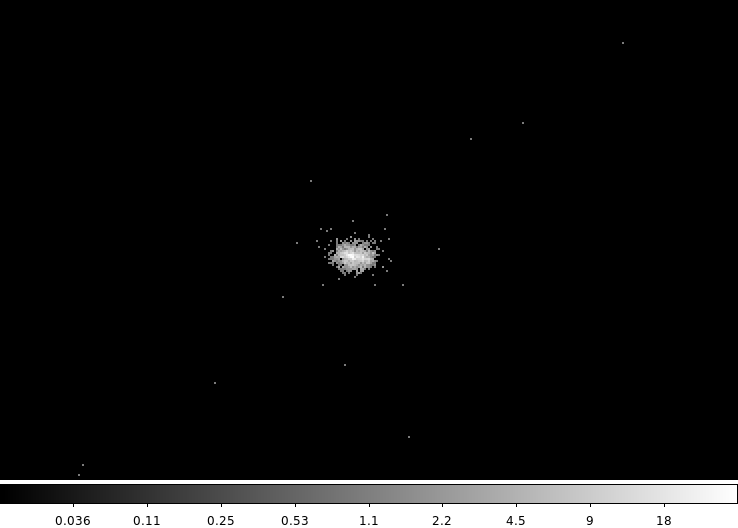

In [46]:
ds9 psf_512_i0000.fits -scale log -zoom 2 \
  -saveimage png ds9_05.png &
sleep 10
xpaset -p ds9 quit
display < ds9_05.png

### Bin ray to match image

In [47]:
dmcopy "acisf00942_repro_evt2.fits[ccd_id=6]" ccd6_evt.fits  clob+

apply_fov_limits ccd6_evt.fits"[energy=400:6000]" ccd6_bin1.fits bin=1 clob+


Running: apply_fov_limits
  version: 01 April 2020
Observation: ObsId 942 - ACIS-235678
Using ccd_id=6 from ccd6_evt.fits[energy=400:6000]
Calculating FOV file using:
  Aspect solution pcadf00942_001N001_asol1.fits
  Mask file       acisf00942_001N005_msk1.fits

The output image will have 1482 by 1481 pixels, pixel size of 0.492 arcsec,
    and cover x=3814.5:5296.5:1,y=2760.5:4241.5:1.

Created: ccd6_bin1.fits


[1] 4782
[1]+  Done                    ds9 ccd6_bin1.fits -scale log -block 1 -saveimage ds9_06.png


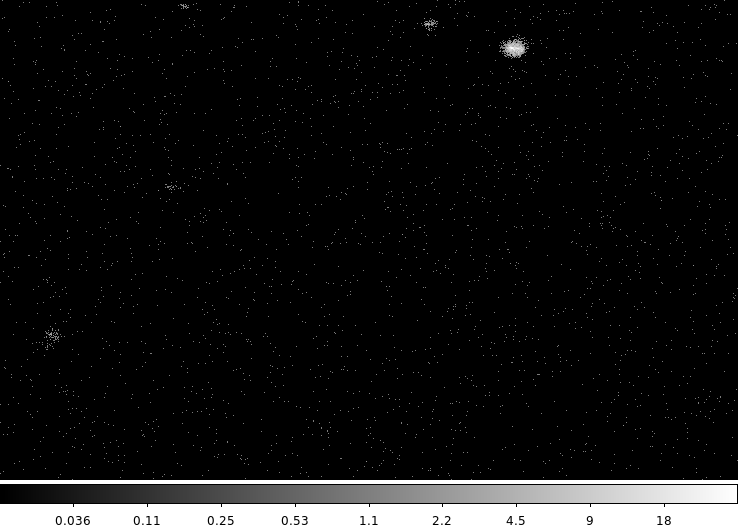

In [48]:
ds9 ccd6_bin1.fits -scale log -block 1 -saveimage ds9_06.png &
sleep 10
xpaset -p ds9 quit
display < ds9_06.png

In [49]:
get_sky_limits ccd6_bin1.fits

Running: get_sky_limits
  version: 07 October 2016
Checking binning of image: ccd6_bin1.fits
  Image has 1482 x 1481 pixels
  Pixel size is 1.0 by 1.0
  Lower left (0.5,0.5) corner is x,y= 3814.5, 2760.5
  Upper right (1482.5,1481.5) corner is x,y= 5296.5, 4241.5
  DM filter is:
    x=3814.5:5296.5:#1482,y=2760.5:4241.5:#1481
  mkexpmap xygrid value is:
    3814.5:5296.5:#1482,2760.5:4241.5:#1481


In [50]:
dmcopy "marx_output_i0000.fits[bin x=3821.5:5302.5:#1481,y=2768.5:4248.5:#1480]" \
  psf_match_i0000.fits clob+

[1] 4850
[1]+  Done                    ds9 -scale log psf_match_i0000.fits ccd6_bin1.fits -pan to 4707 3699 physical -match frame wcs -saveimage png ds9_07.png


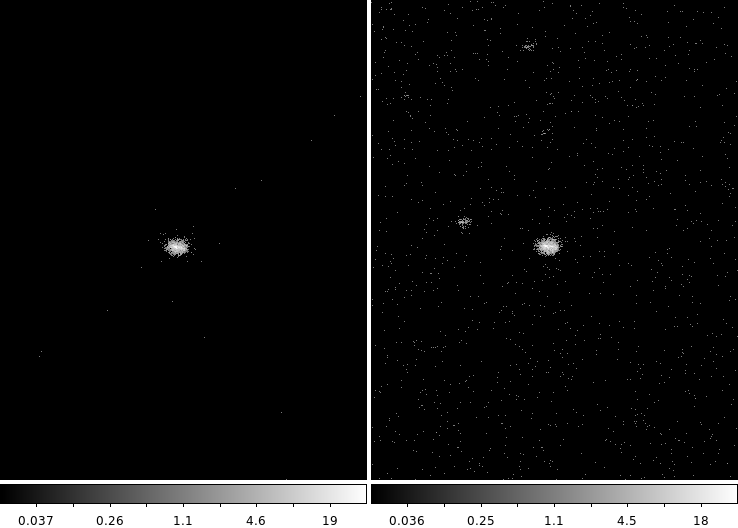

In [51]:
ds9 -scale log psf_match_i0000.fits ccd6_bin1.fits -pan to 4707 3699 physical \
  -match frame wcs \
  -saveimage png ds9_07.png &
sleep 10
xpaset -p ds9 quit
display < ds9_07.png

### Create subpixel

In [52]:
 dmcopy "marx_output_i0000.fits[bin x=3820.5:5302.5:0.1,y=2768.5:4248.5:0.1]" psf_subpix.fits clob+

[1] 5033
[1]+  Done                    ds9 psf_subpix.fits -scale log -pan to 4707 3699 physical -regions command 'physical; box(4727,3679,1,1,0)' -saveimage png ds9_08.png
XPA$ERROR no 'xpaset' access points match template: ds9


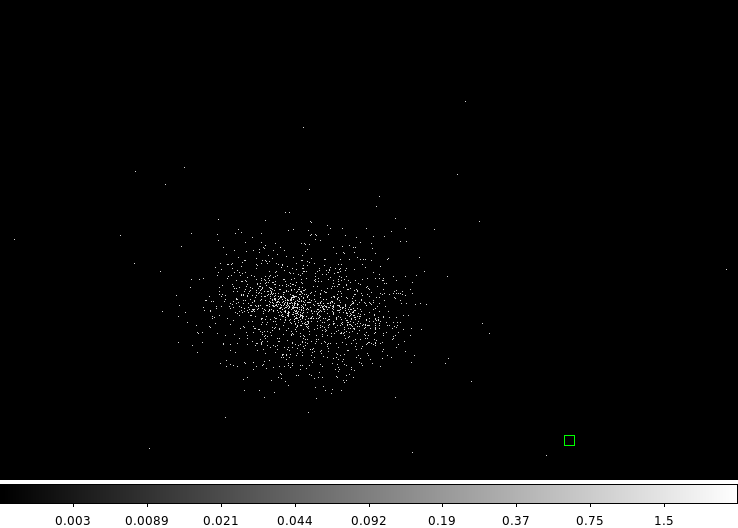

In [53]:
ds9  psf_subpix.fits -scale log  -pan to 4707 3699 physical \
  -region format ds9 \
  -region command 'physical; box(4727,3679,1,1,0)' \
  -saveimage png ds9_08.png &
sleep 10
xpaset -p ds9 quit

display < ds9_08.png


### Combine multiple realizations

In [54]:
for i in 0 1 2 3 4 5 6 7 8 9
do
  d=i000$i
  marx @@./marx OutputDir=marx_output_${d}.dir SAOSACFile=HRMA_ra184.23746_dec37.72658_${myid}.dat_dithered_${d}_rays.fits
  marx2fits --pixadj=EDSER marx_output_${d}.dir marx_output_${d}.fits
done


MARX version 5.5.1, Copyright (C) 2002-2020 Massachusetts Institute of Technology

	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/EKCHDOS06.rdb
Reading binary HRMA optical constants:
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/iridium.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_1.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_3.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_4.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_6.dat
Reading scattering tables
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_h1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p3_M.bin
	/export/CIAOT/ciaot

[Using ASPSOL dither model]
Initializing source type SAOSAC...
Opening SAOSAC fits file HRMA_ra184.23746_dec37.72658_1636553544.dat_dithered_i0001_rays.fits
System initialized.

Starting simulation.  NumRays to collect = 1000000, dNumRays = 100000
	8714 collected.
Reflecting from HRMA
Detecting with ACIS-S

Writing output to directory 'marx_output_i0001.dir' ...
Total photons: 8714, Total Photons detected: 1612, (efficiency: 0.184990)
  (efficiency this iteration  0.184990)  Total time: 50301.494021

Reading subpix file /export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-07-22subpixN0001_marx.fits
Examining marx_output_i0001.dir/time.dat
Examining marx_output_i0001.dir/detector.dat
Examining marx_output_i0001.dir/energy.dat
Examining marx_output_i0001.dir/b_energy.dat
Examining marx_output_i0001.dir/xpos.dat
Examining marx_output_i0001.dir/ypos.dat
Examining marx_output_i0001.dir/zpos.dat
Examining marx_output_i0001.dir/xcos.dat
Examining marx_outp

Reading ACIS5 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 5]
Reading ACIS6 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 6]
Reading ACIS7 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 7]
Reading ACIS8 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_

	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_3.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_4.dat
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/corr_6.dat
Reading scattering tables
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_h1_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p3_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_h3_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p4_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_h4_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/hrma/scat_p6_M.bin
	/export/CIAOT/ciaot_install/20211019/ciao-

Total photons: 8821, Total Photons detected: 1604, (efficiency: 0.181839)
  (efficiency this iteration  0.181839)  Total time: 50309.991351

Reading subpix file /export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-07-22subpixN0001_marx.fits
Examining marx_output_i0006.dir/time.dat
Examining marx_output_i0006.dir/detector.dat
Examining marx_output_i0006.dir/energy.dat
Examining marx_output_i0006.dir/b_energy.dat
Examining marx_output_i0006.dir/xpos.dat
Examining marx_output_i0006.dir/ypos.dat
Examining marx_output_i0006.dir/zpos.dat
Examining marx_output_i0006.dir/xcos.dat
Examining marx_output_i0006.dir/ycos.dat
Examining marx_output_i0006.dir/zcos.dat
Examining marx_output_i0006.dir/xpixel.dat
Examining marx_output_i0006.dir/ypixel.dat
Examining marx_output_i0006.dir/pha.dat
Examining marx_output_i0006.dir/mirror.dat
Examining marx_output_i0006.dir/sky_ra.dat
Examining marx_output_i0006.dir/sky_dec.dat
Examining marx_output_i0006.dir/sky_roll.dat
E

	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 6]
Reading ACIS7 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 7]
Reading ACIS8 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1997-04-17qeN0006.fits for [CCDID = 8]
Reading ACIS9 Contamination File
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5.5.1/share/marx/data/caldb/acisD1999-08-13contamN0014_marx.fits
	/export/CIAOT/ciaot_install/20211019/ciao-4.14/marx-5

In [55]:
dmmerge "marx_output_i00*.fits" marx_output.fits clob+
cts=`dmlist marx_output.fits counts`
dmimgcalc "marx_output.fits[bin x=3821.5:5302.5:#1481,y=2768.5:4248.5:#1480]" none norm_psf.fits op="imgout=img1/((float)${cts})" clob+

[1] 5151
[1]+  Done                    ds9 norm_psf.fits -scale log -pan to 4707 3699 physical -zoom 2 -saveimage png ds9_10.png


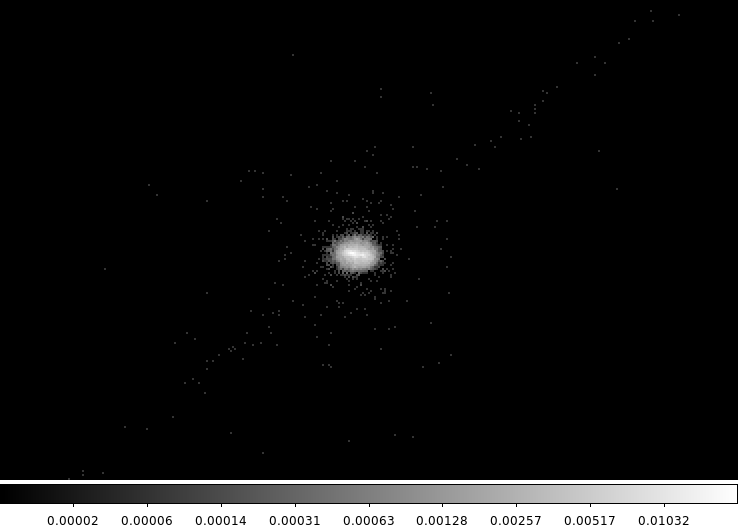

In [56]:
ds9 norm_psf.fits -scale log -pan to 4707 3699 physical \
  -zoom 2 \
  -saveimage png ds9_10.png &
sleep 10
xpaset -p ds9 quit

display < ds9_10.png

In [57]:
dmlist "marx_output.fits" counts

15493   



# Cleanup

In [58]:
/bin/rm -rf marx*dir/
/bin/rm -f ${myid}.dat
/bin/rm -f acisf*fits 
/bin/rm -f pcadf*fits pcad_asol.fits
/bin/rm -rf marx-5.*
/bin/rm -rf 942
/bin/rm -f HRMA_*_dithered.tar.gz
/bin/rm -f ccd6_evt.fits
/bin/rm -f ccd6_bin1.fits
